Проект к лекции № 9 по статистеке

Сасимовича И.С.

# Описание эксперимента

Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом

Описание колонок:
    
* value – значения метрики
* experimentVariant – Вариант теста (Control – контроль, Treatment – тест)

Задача

1. Сравните результат между тестом и контролем по двум кейсам:

* Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
* Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.

2. Напишите выводы, которые можно сделать на основе анализа примененных критериев

❗️ Не сравнивайте p-value разных критериев в реальной жизни
1) Это повышает вероятность допустить ошибку I рода и вводит в заблуждение при анализе результатов применения критериев. 

2) Заранее формулируйте гипотезу и подбирайте под нее релевантный статистический критерий в рамках дизайна эксперимента

### Гипотезы: 

Нулевая гипотеза (H0): ничего не изменилось, выборки тест и контроль равны.

Альтернативная гипотеза (H1): тест и контроль не равны.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, mannwhitneyu
import statsmodels.api as sm
import pingouin as pg
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [3]:
df = pd.read_csv('Проект/hw_bootstrap.csv', sep=';', decimal=',')

In [4]:
df.head()

,Unnamed: 0,value,experimentVariant
0,1,10.380495,Control
1,2,9.546867,Control
2,3,11.088215,Control
3,4,10.147274,Control
4,5,9.789808,Control


In [5]:
df.shape

(1000, 3)

In [6]:
df.dtypes

Unnamed: 0             int64
value                float64
experimentVariant     object
dtype: object

In [7]:
df.isna().sum()
# пропущенные значения отсутствуют

Unnamed: 0           0
value                0
experimentVariant    0
dtype: int64

In [8]:
df.experimentVariant.value_counts() 
# выборки одинакового размера

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

In [9]:
df.groupby('experimentVariant').agg({'value': 'mean'})

,value
experimentVariant,
Control,10.026867
Treatment,27.321499


In [10]:
df.groupby('experimentVariant').agg({'value': 'median'})

,value
experimentVariant,
Control,10.018465
Treatment,10.025847


<AxesSubplot:xlabel='experimentVariant', ylabel='value'>

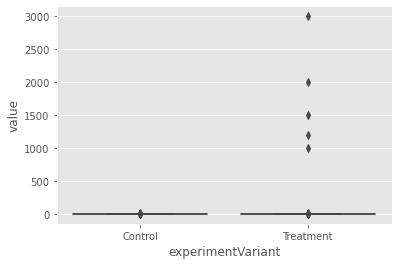

In [11]:
sns.boxplot(x="experimentVariant", y="value", data=df)

In [12]:
df_control = df[df.experimentVariant == 'Control'].value
df_treatment = df[df.experimentVariant == 'Treatment'].value

C:\Users\Ihar237\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value'>

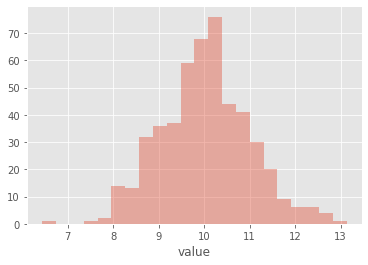

In [13]:
sns.distplot(df_control, kde=False)

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

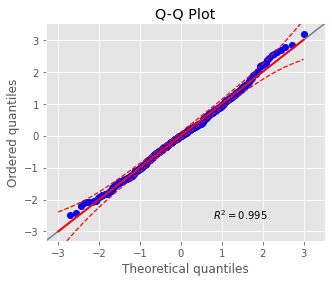

In [14]:
pg.qqplot(df_control)

C:\Users\Ihar237\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value'>

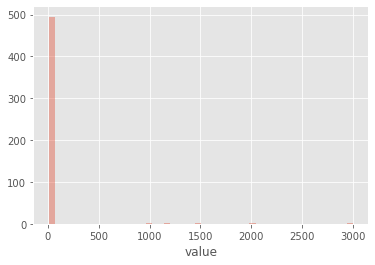

In [15]:
sns.distplot(df_treatment, kde=False)

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

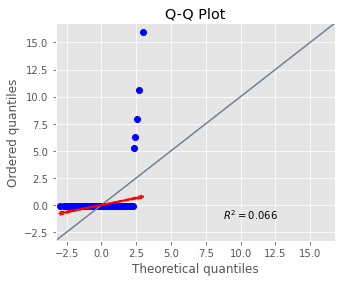

In [16]:
pg.qqplot(df_treatment)

In [17]:
# смотрим на выбросы
df_treatment.quantile(q=0.99)

22.999042271425807

In [18]:
df_treatment[df_treatment > 23]

995    1000.0
996    1200.0
997    1500.0
998    2000.0
999    3000.0
Name: value, dtype: float64

In [19]:
# Считаем критерий mann-whitney
mannwhitneyu(df_treatment, df_control)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

  0%|          | 0/1000 [00:00<?, ?it/s]

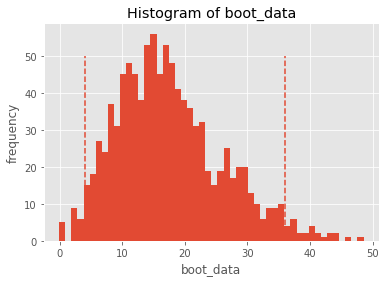

In [20]:
booted_data = get_bootstrap(
    df_treatment, # числовые значения первой выборки
    df_control, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)  # в результате хранится разница двух распределений, ДИ и pvalue

In [21]:
# Значение p-value для mean
booted_data["p_value"]

0.038899166882621676

In [22]:
# Доверительный интервал для mean
booted_data["ci"]

,0
0.025,3.97114
0.975,36.06471


  0%|          | 0/1000 [00:00<?, ?it/s]

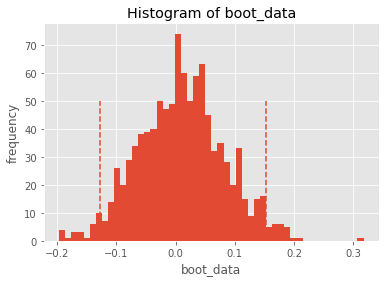

In [23]:
booted_data_median = get_bootstrap(
    df_treatment, # числовые значения первой выборки
    df_control, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)  # в результате хранится разница двух распределений, ДИ и pvalue

In [24]:
# Значение p-value для median
booted_data_median["p_value"]

0.8828197182386225

In [25]:
# Доверительный интервал для median
booted_data_median["ci"]

,0
0.025,-0.128099
0.975,0.152590


### Вывод ###

P-value, полученное  при помощи метода бутстрап по  среднему (0.033), говорит о  статзначимости различий и позволяет отклонить нулевую гиппотизу о равенстве наших выборок. Однако, мы знаем, что статистические показатели расчитываемые на основании средних значений весьма зависимы от нормальности распределения и наличия выбросов, которые согласно нашей визуализации, явно присутствуют в тестовой выборке. Будем ориентироваться на менее зависимые от выбрасов критерии. Медиана не чувствительна к выбросам, как и критерий критерий Манна-Уитни, они ориентированны только на ранговый порядок. 
 
 В ходе дальнейшей проверки, выявленно, что P-value, полученное  при помощи критерия Манна-Уитни (0,86) и при применении метода бутстрап по медиане  (0,89) близки и не дают нам оснований отклонить нулевую гиппотезу (P-value > 0). Также 0 попадает в доверительный интервал для median, следовательно нулевая гипотеза на заданном уровне значимости принимается.
 
Также примем на вооружение совет данный нам в задании:
* ❗️ Не сравнивайте p-value разных критериев в реальной жизни
    * 1) Это повышает вероятность допустить ошибку I рода и вводит в заблуждение при анализе результатов применения критериев. 
    * 2) Заранее формулируйте гипотезу и подбирайте под нее релевантный статистический критерий в рамках дизайна эксперимента

# Ответ преподавателя


Верно следующее утверждение: Манн-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. Что значит равенство распределений? Это значит, что случайно выбранное значение из одной выборки может быть равновероятно больше или меньше случайного значения из другой выборки (иногда путают с равенством медиан, но на самом деле проверяется не только медиана). Также вы верно применили критерии и написали код


Про разное количество наблюдений в выборках: Манн-Уитни как и любой статистический оценщик не очень приветлив к дисбалансу. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект). Подробнее тут https://stats.stackexchange.com/questions/40342/mann-whitney-u-test-with-unequal-sample-sizes

## Итого
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
* U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы

Хорошего дня!